<a href="https://colab.research.google.com/github/arjan-hada/esm2-antibody-CLIP/blob/main/ESM_IF1_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PDB to ESM-IF1 embeddings

In this notebook, I use [ESM-IF1 model](https://www.biorxiv.org/content/10.1101/2022.04.10.487779v1) to obtain antibody structure embedding for train/valid/test pdb files. For my work, I froze the ESM-IF1 model, and average pooled the antibody structure embeddings from the transformer encoder, following the procedure used in the [facebook research ESM-IF1 notebook](https://github.com/facebookresearch/esm/tree/main/examples/inverse_folding).

## Setup

In [ ]:
# Colab environment setup

# Install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric

# Install esm
!pip install -q git+https://github.com/facebookresearch/esm.git

# Install biotite
!pip install -q biotite

# Install proteinflow
!pip install proteinflow &> /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 37.1 MB/s eta 0:00:00


In [ ]:
## Verify that pytorch-geometric is correctly installed
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing

In [ ]:
# Import necessary libraries
import os
import pickle
import pandas as pd
import torch
from tqdm import tqdm
from pathlib import Path
import esm
from proteinflow.data import ProteinEntry
from fastcore.parallel import parallel

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

path = Path("/content/gdrive/")
path_data = Path("/content/gdrive/MyDrive/data")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/gdrive


In [ ]:
# Define directories
train_folder = Path("/content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train")
valid_folder = Path("/content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid")
test_folder = Path("/content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## PDB to ESM-IF1 embeddings

In [ ]:
import time

# Load the ESM-IF1 model and move it to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
esm_if1_model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
esm_if1_model = esm_if1_model.eval().to(device)

# Function to process a batch of PDB files
def process_pdb_batch(pdb_files):
    results = []
    for pdb_file in pdb_files:
        try:
            print(f"Processing {pdb_file}...")  # Log progress

            # Load the protein entry from the pickle file
            protein_entry = ProteinEntry.from_pickle(pdb_file)

            # Convert to PDB format
            pdb_path = str(pdb_file).replace('.pickle', '.pdb')
            protein_entry.to_pdb(pdb_path)

            # Load the structure and extract coordinates and sequence
            structure = esm.inverse_folding.util.load_structure(pdb_path)
            coords, native_seq = esm.inverse_folding.util.extract_coords_from_structure(structure)
            coords = torch.tensor(coords, dtype=torch.float32).to(device)

            with torch.no_grad():
                rep = esm.inverse_folding.util.get_encoder_output(esm_if1_model, alphabet, coords)

            # Average pooling
            embedding = rep.mean(dim=0).detach().cpu().numpy()

            # Remove the temporary PDB file
            os.remove(pdb_path)

            # Add result to batch
            results.append({
                'id': pdb_file.stem,
                'sequence': native_seq,
                'embedding': embedding
            })

        except Exception as e:
            print(f"Error processing {pdb_file}: {e}")
            results.append(None)
    return results

# Function to process and extract data from PDB files in a directory using batching
def process_pdb_files(data_dir, output_file, batch_size=8):
    pdb_files = list(data_dir.glob("*.pickle"))
    all_results = []

    for i in tqdm(range(0, len(pdb_files), batch_size)):
        batch_files = pdb_files[i:i + batch_size]
        batch_results = process_pdb_batch(batch_files)
        all_results.extend(batch_results)

    # Filter out None results (errors)
    records = [result for result in all_results if result is not None]

    # Save the records to a DataFrame and then to a pickle file
    df = pd.DataFrame(records)
    df.to_pickle(output_file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!mkdir -p {path_data}/'proteinflow_esmif1_20240520-0899946'
# Process and save data for train, valid, and test sets
process_pdb_files(train_folder, path_data/'proteinflow_esmif1_20240520-0899946/train_data.pkl')
process_pdb_files(valid_folder, path_data/'proteinflow_esmif1_20240520-0899946/valid_data.pkl')
process_pdb_files(test_folder, path_data/'proteinflow_esmif1_20240520-0899946/test_data.pkl')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/197 [00:00<?, ?it/s]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4r4b-F_E_nan.pickle...


/usr/local/lib/python3.10/dist-packages/esm/inverse_folding/util.py:251: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.pad(torch.tensor(cd), (0, 0, 0, 0, 1, 1), value=np.inf)


Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4r4b-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4r4b-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4r4b-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1l7i-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ly2-F_C_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ly2-N_O_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ly2-H_L_A.pickle...


  1%|          | 1/197 [00:07<22:55,  7.02s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ly2-G_I_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ly2-M_K_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ly2-E_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5hi3-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5hi3-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ush-H_L_X.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ush-D_E_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6b9y-B_A_C | E.pickle...


  1%|          | 2/197 [00:12<19:32,  6.01s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ibu-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ibu-G_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5hi5-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ce2-Z_B_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4zso-D_C_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kza-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5cck-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7n07-H_L_nan.pickle...


  2%|▏         | 3/197 [00:37<47:11, 14.60s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4zso-B_A_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6dwc-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6dwc-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3mxw-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5vr9-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5vr9-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6bhz-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7e9b-H_L_C.pickle...


  2%|▏         | 4/197 [00:39<31:16,  9.72s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6bhz-I_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6p9i-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6p9i-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2h9g-B_A_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4yhy-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4yhy-B_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6p9j-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6p9j-A_B_nan.pickle...


  3%|▎         | 5/197 [00:41<22:21,  6.99s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6pze-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xul-J_K_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xul-G_I_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xul-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xul-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xul-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xul-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3qhf-H_L_nan.pickle...


  3%|▎         | 6/197 [00:43<17:08,  5.38s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7msq-D_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3upa-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7msq-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3eo9-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3upa-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5mud-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5fhb-H_L_nan.pickle...


  4%|▎         | 7/197 [00:45<13:16,  4.19s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5mud-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1ohq-B_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ub0-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7vyr-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1ohq-A_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7vyr-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2yss-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wzl-C_D_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wzl-A_B_E.pickle...


  4%|▍         | 8/197 [00:47<10:56,  3.47s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5vkd-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7coe-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7coe-B_C_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5uea-A_B_X.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4m5y-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4m5y-I_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4nrz-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4nrz-H_L_nan.pickle...


  5%|▍         | 9/197 [00:49<09:45,  3.11s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7e7y-C_D_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7e7y-A_B_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ca6-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ca6-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ggu-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ggu-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6dlb-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1rzf-H_L_nan.pickle...


  5%|▌         | 10/197 [00:51<08:48,  2.82s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lfa-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lfa-B_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7or9-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7or9-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kfy-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7bnv-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7dc7-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4kq3-H_L_nan.pickle...


  6%|▌         | 11/197 [00:54<08:25,  2.72s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wgj-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7r6w-A_B_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wgj-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7rxj-A_B_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7r6w-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wgj-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7rxj-H_L_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3hi5-H_L_nan.pickle...


  6%|▌         | 12/197 [00:56<07:57,  2.58s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4hh9-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4hh9-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ca7-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7f7e-C_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4zyk-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4zyk-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5occ-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4g7v-H_L_S.pickle...


  7%|▋         | 13/197 [00:59<07:41,  2.51s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mx8-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6apc-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6a67-C_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6a67-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ke1-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ke1-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ieb-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3l5x-H_L_A.pickle...


  7%|▋         | 14/197 [01:01<07:33,  2.48s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5u3d-B_A_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6c9u-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2vxq-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4wuk-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6q1k-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7zff-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ygv-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ygv-F_L_nan.pickle...


  8%|▊         | 15/197 [01:04<07:45,  2.56s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4nzt-H_L_M.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5u15-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5u15-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wos-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6uyd-A_B_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7vyt-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7vyt-H_L_T.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7cjf-A_B_C.pickle...


  8%|▊         | 16/197 [01:06<07:26,  2.47s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6b0g-D_C_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4nki-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3qyc-A_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3qyc-B_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4f57-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6tkd-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mee-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mee-C_D_nan.pickle...


  9%|▊         | 17/197 [01:08<06:48,  2.27s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1rz8-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1rz8-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7so5-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mzf-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ztr-H_L_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ztr-A_B_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5te6-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lm8-H_L_A.pickle...


  9%|▉         | 18/197 [01:11<07:24,  2.48s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lm8-M_N_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ugt-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4xmp-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ugt-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7rxi-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ket-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4olz-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4yhn-A_B_nan.pickle...


 10%|▉         | 19/197 [01:13<07:28,  2.52s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4yhn-F_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7rxl-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7rxl-C_D_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lxy-E_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lxy-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lxy-N_O_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lxy-F_C_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6iuv-C_D_B.pickle...


 10%|█         | 20/197 [01:17<08:51,  3.00s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lxy-G_I_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2g75-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lxy-M_K_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2g75-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6iuv-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6y1k-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4tsb-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6b0w-H_L_nan.pickle...


 11%|█         | 21/197 [01:21<08:55,  3.04s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4npy-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3gje-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4npy-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3lve-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7urq-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2nxz-D_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7bz5-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3gje-H_L_nan.pickle...


 11%|█         | 22/197 [01:23<08:08,  2.79s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6o89-H_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6o89-nan_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3inu-M_N_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3inu-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5kw9-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6srv-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6srv-I_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5sx5-J_K_M.pickle...


 12%|█▏        | 23/197 [01:25<07:35,  2.62s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5v7u-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5sx5-H_L_N.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6be2-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3ma9-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6j9o-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5u4r-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5u4r-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5t6l-A_B_G.pickle...


 12%|█▏        | 24/197 [01:27<07:11,  2.49s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5t6l-H_L_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1fvd-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1fvd-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7dun-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4r26-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1rzj-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lop-W_V_Z.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ss5-H_L_nan.pickle...


 13%|█▎        | 25/197 [01:30<07:03,  2.46s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lop-X_Y_Z.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lop-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5wuv-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lop-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7chs-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6aod-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4xak-D_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4xak-H_L_A.pickle...


 13%|█▎        | 26/197 [01:32<07:17,  2.56s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4olx-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ik3-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ik3-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3dif-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mft-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mft-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3zhd-B_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3zhd-A_nan_nan.pickle...


 14%|█▎        | 27/197 [01:35<06:58,  2.46s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3dif-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2eiz-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7k3q-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ugv-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ugv-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2vxv-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wpv-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6bi0-I_M_nan.pickle...


 14%|█▍        | 28/197 [01:37<06:30,  2.31s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5m76-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6bi0-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5m76-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5jrp-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5od0-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5tfs-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i1k-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5k9j-H_L_nan.pickle...


 15%|█▍        | 29/197 [01:38<06:01,  2.15s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5tdn-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7urs-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ewi-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5whk-H_L_A | B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7nc0-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5tdn-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6q19-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5od8-A_B_nan.pickle...


 15%|█▌        | 30/197 [01:41<06:06,  2.20s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kmh-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7nx6-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7nx6-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kzc-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4hwe-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ele-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ele-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4llw-A_B_nan.pickle...


 16%|█▌        | 31/197 [01:43<06:10,  2.23s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4llw-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5if0-A_B_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3naa-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5if0-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2ny5-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7cr5-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6phh-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6phh-A_B_nan.pickle...


 16%|█▌        | 32/197 [01:46<06:32,  2.38s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3n9g-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5tf1-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1gc1-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6azz-F_E_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3qhz-I_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2w0k-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2w0k-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3qhz-H_L_nan.pickle...


 17%|█▋        | 33/197 [01:48<06:07,  2.24s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6azz-C_B_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5gks-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5gks-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5waw-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7q0g-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7q0g-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1yym-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1yym-R_Q_P.pickle...


 17%|█▋        | 34/197 [01:50<06:22,  2.35s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5w1g-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6q20-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ogy-M_N_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ogy-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5uek-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6qb6-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7neh-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i1h-H_L_nan.pickle...


 18%|█▊        | 35/197 [01:53<06:39,  2.46s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6az2-C_E_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6sm2-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6dfi-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6sm2-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4jpi-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4jpi-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6dzn-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6w7s-H_L_A.pickle...


 18%|█▊        | 36/197 [01:55<06:17,  2.34s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5tdo-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5tdo-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5b71-B_A_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4h8w-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5b71-D_C_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kmg-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kmg-D_E_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1t3f-B_A_nan.pickle...


 19%|█▉        | 37/197 [01:57<06:19,  2.37s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5zmj-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6my5-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6my5-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rcq-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ugu-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ugu-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5vsi-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6q0e-H_L_A.pickle...


 19%|█▉        | 38/197 [02:00<06:07,  2.31s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2zkh-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7djz-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5cex-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5cex-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ezi-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7jxd-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7jxd-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ps1-A_B_E.pickle...


 20%|█▉        | 39/197 [02:02<06:01,  2.29s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5hhv-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6b0a-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5bk1-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5bk1-C_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6oc7-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6k0y-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6phb-D_C_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6phb-B_A_E.pickle...


 20%|██        | 40/197 [02:05<06:20,  2.43s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7rdk-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7jie-E_F_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7jie-C_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mu4-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3w9d-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3w9d-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4fq2-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4hjg-B_A_H | E.pickle...


 21%|██        | 41/197 [02:07<06:17,  2.42s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7zf6-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4xnq-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5u5f-B_A_C | E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4xnq-B_A_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3fct-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5drw-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wyt-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6cw3-C_D_F | E.pickle...


 21%|██▏       | 42/197 [02:09<06:16,  2.43s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6a3w-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7e72-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6a3w-J_K_L.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7e72-C_D_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6a3w-G_H_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ps4-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ps4-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3lev-H_L_A.pickle...


 22%|██▏       | 43/197 [02:12<06:11,  2.42s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4qci-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4qci-B_A_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kfx-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6sm1-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7chb-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ucb-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7k8n-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3fzu-C_D_nan.pickle...


 22%|██▏       | 44/197 [02:14<05:59,  2.35s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3fzu-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5wk2-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1eeq-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1eeq-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ocb-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4m62-I_M_T.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4m62-H_L_S.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7so9-C_B_A.pickle...


 23%|██▎       | 45/197 [02:16<05:49,  2.30s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7so9-E_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7so9-H_G_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7so9-J_I_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7so9-M_L_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7so9-O_N_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5dk3-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5dk3-G_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5adp-H_L_nan.pickle...


 23%|██▎       | 46/197 [02:21<07:21,  2.93s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mzm-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6dkj-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4gxv-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6dkj-A_B_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mzi-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4gxv-I_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5uel-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7b3o-H_L_E.pickle...


 24%|██▍       | 47/197 [02:23<07:03,  2.82s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3w9e-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5cgy-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5tjd-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5cgy-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6m3b-C_B_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5weq-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6o3d-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kez-H_L_V.pickle...


 24%|██▍       | 48/197 [02:26<06:36,  2.66s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mtx-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5f9o-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kf0-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6k6b-nan_A_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kf0-H_L_V.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1iqd-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4gsd-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4lsp-H_L_G.pickle...


 25%|██▍       | 49/197 [02:28<06:22,  2.59s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2mcg-nan_2_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2mcg-nan_1_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4lri-C_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6elj-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4lri-P_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6elj-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4unv-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ioi-B_A_H | E.pickle...


 25%|██▌       | 50/197 [02:30<05:42,  2.33s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lm9-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5itb-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6nis-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2nxy-D_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5f96-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ot1-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4nrx-D_E_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5e8e-B_A_H.pickle...


 26%|██▌       | 51/197 [02:32<05:53,  2.42s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mfb-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5n7w-H_L_X.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4kmt-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6b0s-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7sd5-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6l98-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6l98-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7k8q-H_L_nan.pickle...


 26%|██▋       | 52/197 [02:34<05:30,  2.28s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4yhl-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2cd0-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2cd0-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mlk-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3u7a-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6iea-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4l1h-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7qf0-H_L_A.pickle...


 27%|██▋       | 53/197 [02:36<05:17,  2.21s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5wca-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7n3e-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7km6-h_l_nan.pickle...
Error processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7km6-h_l_nan.pickle: Chain IDs must be single uppercase letters, please rename with `rename_chains` before saving.
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4lly-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4lly-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6uyf-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7km6-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4o5l-H_L_nan.pickle...


 27%|██▋       | 54/197 [02:38<04:57,  2.08s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5d7s-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4cni-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4cni-A_B_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5f7e-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5tpp-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2yc1-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2yc1-D_E_F.pickle...


 28%|██▊       | 55/197 [02:40<04:48,  2.03s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4x4x-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1aqk-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4x4x-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wzj-C_D_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wzj-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4tsc-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7nfa-C_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7nfa-D_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7sn1-H_L_nan.pickle...


 28%|██▊       | 56/197 [02:42<04:46,  2.03s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7a3n-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3skj-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ocr-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5y11-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wj0-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2uzi-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5wkz-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4lsr-H_L_G.pickle...


 29%|██▉       | 57/197 [02:45<05:09,  2.21s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6vpy-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2xwt-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6vpy-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5y9k-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6k67-nan_A_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6k67-nan_C_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7uel-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5oca-H_L_B | A.pickle...


 29%|██▉       | 58/197 [02:47<05:07,  2.21s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6pzg-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5d71-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wzm-C_D_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1qac-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2ny2-D_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1qac-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wzm-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4fqj-H_L_A.pickle...


 30%|██▉       | 59/197 [02:49<05:01,  2.18s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6e56-G_I_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6e56-H_J_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3k2u-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4osu-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6cnr-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7n3f-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6tkc-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ghg-H_L_nan.pickle...


 30%|███       | 60/197 [02:51<05:08,  2.25s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ghg-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4jam-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4jam-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5l6q-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5l6q-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4f58-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1efq-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4f58-K_O_nan.pickle...


 31%|███       | 61/197 [02:53<04:35,  2.03s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4f58-I_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4f58-J_N_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1lve-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4m6m-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4nwu-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3tcl-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6nb8-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3tcl-A_B_nan.pickle...


 31%|███▏      | 62/197 [02:55<04:28,  1.99s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6q0l-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5dr5-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wg8-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6o39-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3pgf-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4hie-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3u7y-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5vvf-H_L_nan.pickle...


 32%|███▏      | 63/197 [02:57<04:48,  2.15s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kn3-M_N_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kn3-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5u6a-B_A_C | E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1igm-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3nab-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3dgg-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2d7t-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3dgg-B_A_nan.pickle...


 32%|███▏      | 64/197 [02:59<04:42,  2.13s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5t85-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4xny-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wgb-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6meg-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4uu9-H_L_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4uu9-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mf8-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7k8p-H_L_nan.pickle...


 33%|███▎      | 65/197 [03:01<04:39,  2.12s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6dla-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wo4-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6q1e-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3giz-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lse-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i1g-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4i77-H_L_Z.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kmi-A_B_C.pickle...


 34%|███▎      | 66/197 [03:04<04:43,  2.17s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5te7-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7n3c-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5drx-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5drx-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6lxi-C_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3qeg-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4uv7-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6lxi-H_L_A.pickle...


 34%|███▍      | 67/197 [03:07<05:10,  2.39s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3dvf-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6pe7-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5w2b-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xca-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4d9q-E_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mf1-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4d9q-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7k8o-H_L_nan.pickle...


 35%|███▍      | 68/197 [03:09<05:02,  2.35s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1h0d-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6fg1-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lsg-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6fg1-A_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7fcq-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3grw-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7k8r-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7e8m-H_L_E.pickle...


 35%|███▌      | 69/197 [03:11<05:03,  2.37s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2dd8-H_L_S.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2ny4-D_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3gkw-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7n4j-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2f5a-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6o1f-H_L_A | I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7beh-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ps6-H_L_E.pickle...


 36%|███▌      | 70/197 [03:14<05:15,  2.48s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ps6-C_D_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7rdj-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1cd0-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1cd0-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2qqn-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7bek-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3nac-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7bei-H_L_E.pickle...


 36%|███▌      | 71/197 [03:16<04:57,  2.36s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6v4q-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ggq-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ies-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7o52-H_L_U.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5eii-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6c6z-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6c6z-C_D_A.pickle...


 37%|███▋      | 72/197 [03:18<04:52,  2.34s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1t2j-A_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7r8u-H_L_A | B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4al8-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3zl4-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7jxe-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7chp-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7rp2-H_I_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i1i-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1jpt-H_L_nan.pickle...


 37%|███▋      | 73/197 [03:21<04:52,  2.36s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ifa-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ivz-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6bla-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4j6r-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7n4i-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6qbc-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ttm-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5d70-H_L_A.pickle...


 38%|███▊      | 74/197 [03:23<04:56,  2.41s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5grv-L_K_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4nwt-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mtr-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xzw-H_L_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4olv-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ss2-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7l7d-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7rp3-H_I_A.pickle...


 38%|███▊      | 75/197 [03:26<04:59,  2.45s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4xvs-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5it2-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5sy8-H_L_O.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4fql-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4lsq-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3ncj-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8c67-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8c67-A_B_nan.pickle...


 39%|███▊      | 76/197 [03:28<04:56,  2.45s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8c67-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8c67-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8uky-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8uky-B_A_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8gdo-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8w0w-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8gkk-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sdf-H_L_Z.pickle...


 39%|███▉      | 77/197 [03:31<04:52,  2.44s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sdf-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8siq-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8siq-M_N_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8jel-C_D_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8jel-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8jel-F_G_H.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8jel-I_K_L.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8jeo-E_F_D.pickle...


 40%|███▉      | 78/197 [03:33<04:55,  2.48s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8jeo-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8r1c-D_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8r1c-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8r1c-F_G_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8jep-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8jep-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8r1d-F_G_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8r1d-D_E_C.pickle...


 40%|████      | 79/197 [03:38<05:54,  3.01s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8jeq-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8r1d-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8cbf-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7y3o-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8cbf-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8f2t-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hpf-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hpf-M_N_A.pickle...


 41%|████      | 80/197 [03:41<05:50,  2.99s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hws-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hws-I_J_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hws-D_E_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8t58-A_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8t58-D_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8bk2-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8t58-C_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8bk2-D_E_B.pickle...


 41%|████      | 81/197 [03:43<05:18,  2.75s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8bk2-F_G_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8t7g-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8t58-F_E_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8ti4-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8tjf-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8tjf-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8ts5-A_G_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8ts5-B_C_nan.pickle...


 42%|████▏     | 82/197 [03:45<04:54,  2.56s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8trs-A_G_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8g19-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hes-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8g1b-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8g1b-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8ez3-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8g1c-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8g1c-C_D_nan.pickle...


 42%|████▏     | 83/197 [03:47<04:41,  2.47s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8f5i-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8f5i-X_Y_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8gye-B_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8gye-E_F_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8szy-A_B_T.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8szy-C_D_U.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8szy-H_L_T.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8szy-I_M_U.pickle...


 43%|████▎     | 84/197 [03:49<04:35,  2.43s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8awl-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8oxx-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8eqc-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8eqc-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5xj4-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7yv1-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8oxw-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dkf-H_L_nan.pickle...


 43%|████▎     | 85/197 [03:52<04:41,  2.52s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8byu-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8oxv-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7yd3-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7yd3-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8oxy-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7yd3-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7yd3-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dkf-A_B_nan.pickle...


 44%|████▎     | 86/197 [03:55<04:36,  2.50s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dzw-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dzw-J_N_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dzw-I_M_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8guz-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8gv1-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8guz-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8ivx-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8jbj-A_B_nan.pickle...


 44%|████▍     | 87/197 [03:58<04:48,  2.62s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8jbj-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8d9y-B_A_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8d9y-D_C_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8d9y-F_E_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8d9y-H_G_L.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8d9z-B_A_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8e8y-H_L_1 | 2 | 3.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8ojt-H_L_nan.pickle...


 45%|████▍     | 88/197 [04:00<04:40,  2.57s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8oju-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8da0-B_A_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8ojv-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8gbv-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8gbv-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8gbw-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8a44-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8slb-H_L_A.pickle...


 45%|████▌     | 89/197 [04:02<04:31,  2.51s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8cwi-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8cwj-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8cwj-J_K_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8cwj-A_B_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8cwk-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8cwk-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8cwj-U_V_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8ahn-H_L_A.pickle...


 46%|████▌     | 90/197 [04:05<04:39,  2.61s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hn6-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7st5-h_l_F.pickle...
Error processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7st5-h_l_F.pickle: Chain IDs must be single uppercase letters, please rename with `rename_chains` before saving.
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hn6-C_D_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7st5-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8bsf-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8bse-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xsa-B_C_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xsa-H_I_J.pickle...


 46%|████▌     | 91/197 [04:07<04:21,  2.46s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wn2-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wn2-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wnb-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xj9-G_F_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xj9-I_H_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xj6-E_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xj9-K_J_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xj6-G_F_B.pickle...


 47%|████▋     | 92/197 [04:11<04:41,  2.68s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8i5h-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8i5h-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8i5h-E_F_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sar-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sar-H_I_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sar-M_N_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xj8-G_F_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xj6-K_J_B.pickle...


 47%|████▋     | 93/197 [04:14<05:05,  2.94s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xj6-I_H_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sas-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xj8-I_H_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xj8-K_J_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sas-M_N_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sas-H_I_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sau-M_N_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sau-H_I_F.pickle...


 48%|████▊     | 94/197 [04:18<05:40,  3.30s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sau-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sav-G_H_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sav-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sav-K_L_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sax-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sax-G_H_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8saw-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8saw-H_I_E.pickle...


 48%|████▊     | 95/197 [04:21<05:30,  3.24s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sax-K_L_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8say-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8say-H_I_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8saw-M_N_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8say-M_N_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8saz-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8saz-H_I_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8saz-M_N_K.pickle...


 49%|████▊     | 96/197 [04:24<05:21,  3.19s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb0-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb0-H_I_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb0-M_N_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb1-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb1-H_I_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb2-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb2-H_I_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb1-M_N_K.pickle...


 49%|████▉     | 97/197 [04:27<05:15,  3.15s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb2-M_N_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb4-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb3-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb5-C_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb4-H_I_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb4-M_N_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb5-H_I_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb3-H_I_F.pickle...


 50%|████▉     | 98/197 [04:31<05:10,  3.14s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4edw-H_L_V.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb3-M_N_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8d21-H_L_B | A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8d21-J_K_G | I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8d21-E_F_C | D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8d7e-F_G_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8d7e-D_E_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8sb5-M_N_K.pickle...


 50%|█████     | 99/197 [04:34<05:05,  3.12s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8bcz-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8bcz-E_F_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8bcz-A_B_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7u8e-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wsl-H_L_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7u0k-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7u04-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7s5r-H_L_A.pickle...


 51%|█████     | 100/197 [04:36<04:36,  2.85s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7s5r-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ul0-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x63-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x66-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8f5n-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7tqg-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wsc-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x2h-A_B_E.pickle...


 51%|█████▏    | 101/197 [04:38<04:27,  2.79s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x2h-C_D_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8ffe-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xcz-D_E_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ru5-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ru5-D_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xcz-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xda-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xda-D_E_A.pickle...


 52%|█████▏    | 102/197 [04:42<04:49,  3.05s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ru3-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ru3-E_F_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xdb-D_E_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xdk-D_E_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xdb-I_H_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xdk-F_G_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xdb-G_F_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8ath-E_F_B.pickle...


 52%|█████▏    | 103/197 [04:47<05:46,  3.69s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8ath-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xdk-H_I_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xdk-K_J_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7uvs-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7uvs-D_E_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xdk-L_M_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wwk-G_F_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wwk-I_H_C.pickle...


 53%|█████▎    | 104/197 [04:51<05:47,  3.74s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7z2m-D_C_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7z2m-F_E_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7z2m-H_L_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8f6e-D_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8f6e-F_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xdk-N_O_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8f6h-F_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8f6h-D_C_A.pickle...


 53%|█████▎    | 105/197 [04:54<05:25,  3.54s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8f6i-F_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wwi-E_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wwi-I_H_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wwi-G_F_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8f6i-D_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8f6j-F_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wwj-G_F_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wwj-I_H_C.pickle...


 54%|█████▍    | 106/197 [04:59<05:49,  3.84s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8f6j-D_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ycl-A_B_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ycl-H_L_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7yxu-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8ek6-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hhx-F_G_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc2-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc3-D_E_A.pickle...


 54%|█████▍    | 107/197 [05:03<05:48,  3.87s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc3-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc4-D_E_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc4-F_J_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc4-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc4-K_M_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc6-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc8-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc5-H_L_C.pickle...


 55%|█████▍    | 108/197 [05:08<06:20,  4.27s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc5-D_E_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc4-G_I_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc4-N_O_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc9-F_G_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc9-D_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hc9-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hca-D_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wh8-B_A_C.pickle...


 55%|█████▌    | 109/197 [05:14<06:51,  4.68s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hca-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hca-F_G_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hcb-D_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dxt-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hcb-F_G_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8hcb-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ox3-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x28-H_K_G.pickle...


 56%|█████▌    | 110/197 [05:19<07:03,  4.87s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x28-C_D_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x25-E_F_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x25-A_C_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x25-H_K_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wur-E_F_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wur-G_H_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7t25-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7t25-A_B_C.pickle...


 56%|█████▋    | 111/197 [05:24<07:00,  4.88s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wtg-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wtj-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wth-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wti-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wti-G_J_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wti-I_K_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dw2-D_C_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dw2-H_L_B.pickle...


 57%|█████▋    | 112/197 [05:27<06:19,  4.47s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dw3-D_C_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dw3-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7t17-J_K_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7t17-F_G_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wtf-G_J_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wtf-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wtf-I_K_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wtk-G_J_B.pickle...


 57%|█████▋    | 113/197 [05:31<06:05,  4.35s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7myt-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7myt-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wtk-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ugm-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7u5g-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wtk-I_K_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7t97-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7t97-C_D_nan.pickle...


 58%|█████▊    | 114/197 [05:34<05:26,  3.93s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7t97-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7t97-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dfg-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dfg-I_M_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dfh-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x2a-H_K_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x29-F_G_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7yr1-D_F_B.pickle...


 58%|█████▊    | 115/197 [05:38<05:27,  4.00s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x29-H_K_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7yr1-E_G_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7yr1-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7s7i-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7s7i-I_M_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dfi-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7s7i-J_N_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7s7i-U_V_D.pickle...


 59%|█████▉    | 116/197 [05:42<05:18,  3.93s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7s7i-W_X_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7s7i-Y_Z_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7zlk-M_N_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7zlk-S_T_E | B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7zlk-H_L_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7zlk-O_P_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7zlk-Q_R_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7tjq-A_B_C.pickle...


 59%|█████▉    | 117/197 [05:45<04:40,  3.51s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8e7m-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7tjq-D_E_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7tjq-H_L_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ven-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7pkl-H_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xxl-A_C_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wbz-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ubr-E_F_C.pickle...


 60%|█████▉    | 118/197 [05:48<04:22,  3.33s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ubr-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xck-A_B_M.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xco-M_N_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xco-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xco-O_P_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7uce-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dlz-H_nan_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xq8-C_L_nan.pickle...


 60%|██████    | 119/197 [05:52<04:47,  3.68s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xq8-v_R_nan.pickle...
Error processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7xq8-v_R_nan.pickle: Chain IDs must be single uppercase letters, please rename with `rename_chains` before saving.
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dzh-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dzh-E_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dzh-I_J_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dzi-G_F_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dzi-B_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/8dzi-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7str-H_L_C.pickle...


 61%|██████    | 120/197 [05:57<05:01,  3.92s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7sts-A_B_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7z3a-H_L_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7z3a-J_N_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7z3a-K_P_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7v27-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7v23-O_P_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7v23-S_T_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7v23-Q_R_B.pickle...


 61%|██████▏   | 121/197 [06:01<04:56,  3.90s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7vke-B_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7qti-F_E_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7qti-G_H_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7qti-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7qti-I_J_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7sk9-F_E_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wjy-E_F_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wo4-D_E_B.pickle...


 62%|██████▏   | 122/197 [06:06<05:26,  4.35s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wo4-H_I_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wo4-F_G_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wo4-M_N_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wo4-O_P_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wo7-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wo4-Q_R_L.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wo5-D_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7woc-A_B_C.pickle...


 62%|██████▏   | 123/197 [06:12<05:51,  4.75s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wp0-H_L_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7rpt-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wo5-F_G_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7rpt-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7rpt-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7rpt-G_H_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wo5-H_I_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7woa-F_G_C.pickle...


 63%|██████▎   | 124/197 [06:15<05:22,  4.41s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7woa-D_B_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wob-D_B_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wob-F_G_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wob-H_I_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wk0-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wk0-D_E_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wjz-A_C_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wjz-D_N_I.pickle...


 63%|██████▎   | 125/197 [06:21<05:41,  4.74s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x1m-A_B_M.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x1m-C_D_M.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wjz-E_O_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wjz-F_P_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wjz-G_Q_L.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7jmo-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wjz-H_R_M.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7orb-E_F_X.pickle...


 64%|██████▍   | 126/197 [06:25<05:30,  4.65s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7orb-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1jvk-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7orb-C_D_X.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1jvk-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7orb-A_B_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4u3x-A_nan_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4u3x-C_nan_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x6a-H_L_B.pickle...


 64%|██████▍   | 127/197 [06:28<04:38,  3.97s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2ny3-D_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1dcl-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1dcl-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3t0v-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x6a-G_J_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4n1c-nan_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4n1c-nan_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4imk-B_C_nan.pickle...


 65%|██████▍   | 128/197 [06:30<03:54,  3.39s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4imk-A_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4toy-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2ny0-D_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6bi2-I_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6bi2-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i16-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i16-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6okm-H_L_R.pickle...


 65%|██████▌   | 129/197 [06:32<03:26,  3.04s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4llu-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4llu-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7bej-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3mlt-I_G_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3mlt-E_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6l8t-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6l8t-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6l8t-A_B_nan.pickle...


 66%|██████▌   | 130/197 [06:34<03:05,  2.77s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7x6a-I_K_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3hi6-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4qhu-B_A_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i1a-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4qhu-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3hi6-X_Y_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i1a-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6nms-H_L_S.pickle...


 66%|██████▋   | 131/197 [06:37<03:04,  2.79s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6nms-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7dv4-H_nan_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7dv4-D_nan_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1rzg-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7dv4-F_nan_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7dv4-B_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1rzg-A_B_nan.pickle...


 67%|██████▋   | 132/197 [06:38<02:37,  2.42s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1rei-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1rei-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5lve-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6gfe-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7rew-A_B_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6gfe-K_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rco-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rco-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5odb-A_B_nan.pickle...


 68%|██████▊   | 133/197 [06:40<02:25,  2.28s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rlo-A_B_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rlo-E_F_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rlo-G_H_L.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rlo-C_D_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lka-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lka-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4xvt-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lka-H_L_nan.pickle...


 68%|██████▊   | 134/197 [06:43<02:24,  2.30s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wrp-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i1l-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lka-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i1l-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mzk-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mzk-F_E_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mzk-C_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7vux-H_L_A.pickle...


 69%|██████▊   | 135/197 [06:45<02:22,  2.31s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mzk-N_M_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lsi-A_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4aiz-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4aiz-nan_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4aiz-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lsi-B_D_nan.pickle...


 69%|██████▉   | 136/197 [06:46<02:01,  2.00s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4aj0-nan_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4aiz-nan_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4aj0-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4aj0-nan_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6med-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6med-G_I_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4aj0-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6med-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6bf4-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6bf4-B_C_A.pickle...


 70%|██████▉   | 137/197 [06:48<01:58,  1.97s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1rhh-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7amr-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1rhh-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7nx7-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7nx7-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4m5z-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5mp6-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5mp6-P_Q_nan.pickle...


 70%|███████   | 138/197 [06:51<02:04,  2.11s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7n6p-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1jps-H_L_T.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7n6p-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6k69-nan_A_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1eeu-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1eeu-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i18-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1dn0-B_A_nan.pickle...


 71%|███████   | 139/197 [06:52<01:55,  1.99s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1dn0-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6srx-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6srx-I_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3so3-C_B_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6tke-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5mvz-H_L_U.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5mvz-A_B_V.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4om0-H_L_G.pickle...


 71%|███████   | 140/197 [06:55<02:01,  2.14s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1fvc-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1fvc-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4om1-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6lun-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6lun-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6tkb-I_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mtn-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6tkb-H_L_nan.pickle...


 72%|███████▏  | 141/197 [06:57<02:00,  2.15s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5y9j-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4eow-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7jxc-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ggv-H_L_Y.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ams-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ugs-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5bjz-C_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5bjz-D_H_B.pickle...


 72%|███████▏  | 142/197 [07:00<02:06,  2.30s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ugs-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7dm1-D_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7dm1-F_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7nxa-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7nxa-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4lkc-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ell-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5jo5-H_L_nan.pickle...


 73%|███████▎  | 143/197 [07:02<02:07,  2.37s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ell-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5jo5-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2pr4-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5jo5-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1ucb-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5jo5-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rlm-K_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rlm-M_N_nan.pickle...


 73%|███████▎  | 144/197 [07:04<01:59,  2.26s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rlm-I_J_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rlm-O_P_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rlm-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1ol0-B_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rlm-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1ol0-A_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rlm-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6rlm-G_H_nan.pickle...


 74%|███████▎  | 145/197 [07:06<01:49,  2.11s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6o41-B_A_N.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6k64-nan_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6k64-nan_B_H.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6o41-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6o41-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4fze-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6kyz-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6kyz-E_F_D.pickle...


 74%|███████▍  | 146/197 [07:08<01:42,  2.01s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3lrg-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3nps-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3sob-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lyv-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lyv-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lyv-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lyv-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6jep-K_I_F.pickle...


 75%|███████▍  | 147/197 [07:10<01:42,  2.05s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6jep-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5n88-A_nan_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7amq-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5n88-H_nan_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5hi4-C_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6sge-D_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2hff-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2hff-H_L_nan.pickle...


 75%|███████▌  | 148/197 [07:12<01:42,  2.09s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6sge-B_nan_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6oed-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1lhz-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1lhz-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5t93-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6oed-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6oed-A_B_nan.pickle...


 76%|███████▌  | 149/197 [07:13<01:30,  1.89s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5t93-nan_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5t93-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5t93-nan_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kql-H_L_T.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6w03-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xoc-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xoc-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mxs-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mxs-H_L_nan.pickle...


 76%|███████▌  | 150/197 [07:15<01:29,  1.91s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1ek3-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1ek3-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4olu-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6plk-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7qnw-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7qnw-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6plk-I_M_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4pub-H_L_nan.pickle...


 77%|███████▋  | 151/197 [07:18<01:31,  1.99s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5mes-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6yla-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6yla-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kgu-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kgu-F_E_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5c9k-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5c9k-nan_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kgu-H_L_nan.pickle...


 77%|███████▋  | 152/197 [07:19<01:28,  1.97s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2eks-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5c9k-nan_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kgu-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5c9k-nan_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5c9k-nan_E_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5c9k-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5c9k-nan_H_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5c9k-nan_G_nan.pickle...


 78%|███████▊  | 153/197 [07:21<01:14,  1.69s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6iut-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4qf1-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4qf1-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kfv-F_G_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kfv-C_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kfv-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1pw3-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3tnn-E_F_nan.pickle...


 78%|███████▊  | 154/197 [07:23<01:22,  1.92s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3tnn-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1pw3-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4aix-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3tnn-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4aix-nan_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3tnn-C_D_nan.pickle...


 79%|███████▊  | 155/197 [07:24<01:11,  1.70s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4aix-nan_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4aix-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4x4z-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4x4z-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i1j-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wyr-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6w5d-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6w5d-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wyr-I_M_nan.pickle...


 79%|███████▉  | 156/197 [07:26<01:11,  1.75s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5mvg-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5bv7-C_B_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4qxg-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6pzh-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5bv7-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6pzh-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mfa-U_V_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mfa-G_I_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mfa-C_D_nan.pickle...


 80%|███████▉  | 157/197 [07:28<01:18,  1.96s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ztf-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ztf-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mfa-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mfa-M_N_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mfa-Q_R_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mzg-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4jzn-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4jy5-H_L_nan.pickle...


 80%|████████  | 158/197 [07:31<01:18,  2.02s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4jzn-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5tfw-H_L_O.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ggs-C_D_Y.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ggs-A_B_Z.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4d9r-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4d9r-E_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5t29-H_L_O.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7neg-H_L_E.pickle...


 81%|████████  | 159/197 [07:34<01:28,  2.33s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5tz2-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7n3g-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ptt-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6qcu-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6azx-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6azx-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6k3m-nan_A_H.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4fqh-A_B_nan.pickle...


 81%|████████  | 160/197 [07:36<01:21,  2.21s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4fqh-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5wl2-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6e4x-Z_Y_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3h42-H_L_B | A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5wl2-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6peh-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6peh-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7l77-H_L_nan.pickle...


 82%|████████▏ | 161/197 [07:38<01:25,  2.37s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5m6i-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5m6i-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5n4j-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ogx-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6dfj-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6dn0-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5gs1-N_M_nan.pickle...


 82%|████████▏ | 162/197 [07:40<01:15,  2.17s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5gs1-R_Q_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5gs1-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5gs1-P_O_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4hk0-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6dn0-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4hk0-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3b5g-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2omn-nan_A_nan.pickle...


 83%|████████▎ | 163/197 [07:41<01:05,  1.92s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2omn-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3b5g-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6dzr-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mts-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3tnm-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5u5m-B_A_C | E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3tnm-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4oly-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6my4-H_L_nan.pickle...


 83%|████████▎ | 164/197 [07:44<01:06,  2.01s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6my4-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mmo-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mmo-D_E_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2i60-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2i60-R_Q_P.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6o3b-G_E_H.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4rir-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4rir-H_L_nan.pickle...


 84%|████████▍ | 165/197 [07:46<01:09,  2.17s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6o3b-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i1d-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i1d-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5vz1-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5vz1-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2ny1-D_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4i2x-D_C_F.pickle...


 84%|████████▍ | 166/197 [07:49<01:10,  2.27s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2w0l-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4i2x-B_A_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6cr1-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2w0l-nan_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3g6a-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2w0l-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2w0l-nan_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3g6a-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6emj-A_B_nan.pickle...


 85%|████████▍ | 167/197 [07:50<01:03,  2.11s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6emj-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4m6n-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7wro-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mf7-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xq0-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mf7-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xq0-E_F_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mf7-H_L_nan.pickle...


 85%|████████▌ | 168/197 [07:53<01:05,  2.25s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mf7-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ttd-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ttd-C_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6amj-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mzj-F_E_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mzj-C_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mzj-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mzj-N_M_B.pickle...


 86%|████████▌ | 169/197 [07:56<01:07,  2.40s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6amj-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3p0y-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4d9l-J_N_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4wv1-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4d9l-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4wv1-E_D_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4d9l-I_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4d9l-K_O_nan.pickle...


 86%|████████▋ | 170/197 [07:58<01:03,  2.34s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ibt-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7jmp-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7seg-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7seg-A_B_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5cey-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5cey-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6b6z-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6umi-H_L_nan.pickle...


 87%|████████▋ | 171/197 [08:00<01:00,  2.32s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6b6z-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7tus-G_H_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7tus-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7tus-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7tus-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wgk-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wgk-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wgk-G_H_nan.pickle...


 87%|████████▋ | 172/197 [08:02<00:55,  2.24s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wgk-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ut7-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4fqq-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4fqq-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4fqq-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4fqq-F_E_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4jdv-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mzh-H_L_E.pickle...


 88%|████████▊ | 173/197 [08:04<00:53,  2.21s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mzh-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1fgv-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4jdv-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4zd3-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6q1a-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mxr-A_B_nan.pickle...


 88%|████████▊ | 174/197 [08:06<00:47,  2.06s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1pew-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1pew-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mxr-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mtj-D_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6tul-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ss0-I_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3na9-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ss0-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7mdp-H_I_A.pickle...


 89%|████████▉ | 175/197 [08:08<00:45,  2.06s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6x9x-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6x9x-A_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5jpj-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6q1g-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5jpj-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ayz-B_D_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ayz-R_C_M.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1lgv-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1lgv-nan_B_nan.pickle...


 89%|████████▉ | 176/197 [08:10<00:40,  1.91s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5whj-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mtj-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lsb-B_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ezj-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7su0-I_M_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4jy6-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7su0-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6o3a-B_A_E.pickle...


 90%|████████▉ | 177/197 [08:12<00:43,  2.16s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4jy6-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3bdx-nan_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6cbv-H_L_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3bdx-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3bdx-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4s1q-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7bsc-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2i5y-R_Q_P.pickle...


 90%|█████████ | 178/197 [08:14<00:40,  2.11s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2i5y-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ydk-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6dcv-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6dcv-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5y2k-G_H_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5y2k-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5y2k-C_D_nan.pickle...


 91%|█████████ | 179/197 [08:17<00:38,  2.17s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6k6a-nan_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5y2k-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2xza-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3p9w-F_nan_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3p9w-D_nan_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7sem-B_C_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3p9w-B_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3p9w-H_nan_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5aze-H_L_nan.pickle...


 91%|█████████▏| 180/197 [08:19<00:34,  2.06s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5u3p-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5b8c-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3eyq-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5b8c-E_D_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6id4-H_L_A | B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5b8c-H_G_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6id4-C_D_E | F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5b8c-K_J_L.pickle...


 92%|█████████▏| 181/197 [08:21<00:33,  2.12s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2aj3-F_E_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2aj3-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/2aj3-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7dm2-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6btj-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6btj-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3bn9-D_C_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6nmr-A_B_E.pickle...


 92%|█████████▏| 182/197 [08:23<00:33,  2.26s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3bn9-F_E_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6nmr-F_G_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6nmr-J_K_M.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5wcd-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6nmr-H_L_S.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5w6c-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5tpl-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7q0i-H_L_C.pickle...


 93%|█████████▎| 183/197 [08:26<00:34,  2.44s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7n3h-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7q0i-A_B_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wm9-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wm9-E_F_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3mcg-nan_1_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3mcg-nan_2_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6phg-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5n2k-L_K_nan.pickle...


 93%|█████████▎| 184/197 [08:29<00:31,  2.45s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5n2k-P_O_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5n2k-N_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5n2k-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5n2k-J_I_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5n2k-F_E_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1jv5-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5n2k-D_C_nan.pickle...


 94%|█████████▍| 185/197 [08:31<00:26,  2.25s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4lve-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4lve-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7n3i-H_L_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4x0k-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4hkx-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6o3k-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4x0k-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7nx8-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7nx8-A_B_E.pickle...


 94%|█████████▍| 186/197 [08:33<00:25,  2.32s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6vi2-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6vi2-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kf1-D_E_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kf1-G_I_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kf1-H_L_V.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7kf1-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3eyo-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3eyo-D_C_nan.pickle...


 95%|█████████▍| 187/197 [08:35<00:22,  2.29s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4unu-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7sob-H_J_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4unu-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7sob-G_I_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7lsf-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7sob-M_L_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7sob-F_E_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7sob-C_B_A.pickle...


 95%|█████████▌| 188/197 [08:39<00:24,  2.77s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7sob-N_O_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5acm-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6tkf-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5v7r-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7z0x-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mg4-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6mg4-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3uls-B_A_nan.pickle...


 96%|█████████▌| 189/197 [08:41<00:20,  2.58s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3uls-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5wk3-U_T_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5wk3-W_V_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5jr1-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5wk3-S_R_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5wk3-Q_P_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6anp-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6b08-C_B_A.pickle...


 96%|█████████▋| 190/197 [08:44<00:17,  2.49s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6anp-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7nx9-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7nx9-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xc4-X_Y_Z.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3u30-F_E_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xc4-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4fqc-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3u30-C_B_A.pickle...


 97%|█████████▋| 191/197 [08:46<00:15,  2.56s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xxv-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6xxv-D_E_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3b9v-A_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6grz-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6wiy-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3b9v-B_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7s4s-H_L_A.pickle...


 97%|█████████▋| 192/197 [08:48<00:11,  2.30s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3b9v-D_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6grz-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3b9v-C_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1g9m-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/1opg-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4hqq-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6obz-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6obz-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6umh-H_L_nan.pickle...


 98%|█████████▊| 193/197 [08:50<00:09,  2.32s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4hkz-B_A_H | E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6umh-h_l_nan.pickle...
Error processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6umh-h_l_nan.pickle: Chain IDs must be single uppercase letters, please rename with `rename_chains` before saving.
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ihz-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ihz-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ihz-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5ihz-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3lmj-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5awn-H_L_nan.pickle...


 98%|█████████▊| 194/197 [08:52<00:06,  2.20s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4fqi-H_L_B | A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ben-G_I_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ben-H_L_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3aaz-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/3aaz-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ben-A_B_E.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ao0-nan_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6ao0-H_nan_nan.pickle...


 99%|█████████▉| 195/197 [08:55<00:04,  2.33s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ben-D_F_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ydl-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/4ydl-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5wcc-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5wcc-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6hkg-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/6hkg-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5i1c-H_L_nan.pickle...


 99%|█████████▉| 196/197 [08:57<00:02,  2.35s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5tdp-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/5tdp-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/train/7ps3-H_L_nan.pickle...


  0%|          | 0/19 [00:00<?, ?it/s]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8v52-D_C_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8x79-N_nan_A | B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8fdo-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7yds-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8gby-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8gbz-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8gc0-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8f6l-A_B_C.pickle...


  5%|▌         | 1/19 [00:03<01:01,  3.44s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8f6o-A_B_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8hix-N_nan_A | B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8hj0-N_nan_A | B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8hj2-N_nan_A | B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7wvi-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7wvi-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7ox1-A_B_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7ox1-C_D_Z.pickle...


 11%|█         | 2/19 [00:06<00:51,  3.02s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8gv4-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8gv4-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7uvl-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7xp4-N_nan_A | B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7xp5-N_nan_A | B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7xp6-N_nan_A | B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7sjm-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7sjn-D_E_B.pickle...


 16%|█▌        | 3/19 [00:08<00:43,  2.75s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7sjn-F_G_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7sjn-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7sjo-E_F_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7sjo-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7sjo-I_J_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7t9n-N_nan_X | Y.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7utz-N_nan_Y | Z | X.pickle...


 21%|██        | 4/19 [00:11<00:39,  2.62s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7omn-A_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7omn-B_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7omn-C_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/3bj9-nan_1_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8fab-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4p9m-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/8fab-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/1bjm-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/1bjm-nan_B_nan.pickle...


 26%|██▋       | 5/19 [00:12<00:30,  2.15s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7ooi-A_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7ooi-B_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5bvj-H_G_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5bvj-F_E_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5bvj-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5bvj-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6e65-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5hys-A_B_G.pickle...


 32%|███▏      | 6/19 [00:14<00:26,  2.03s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5hys-E_F_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5hys-H_L_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5hys-C_D_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/2h3n-nan_A_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/2h3n-nan_C_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/3qny-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/3qny-B_A_nan.pickle...


 37%|███▋      | 7/19 [00:16<00:24,  2.04s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5m6a-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5m6a-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5m6a-nan_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5m6a-nan_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6tcr-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6n32-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6n32-K_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4jha-H_L_nan.pickle...


 42%|████▏     | 8/19 [00:17<00:20,  1.91s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5dhv-H_L_M.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5dhv-A_B_N.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7ki1-N_nan_A | B | G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6tcp-F_E_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6tcp-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6tcp-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6tcp-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6uum-H_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5ty6-H_L_nan.pickle...


 47%|████▋     | 9/19 [00:20<00:20,  2.01s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7nfr-B_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4jm4-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6nov-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6nov-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5chn-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5chn-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4x7s-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/3oaz-M_K_nan.pickle...


 53%|█████▎    | 10/19 [00:22<00:18,  2.04s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/3oaz-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6tcm-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6tco-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6tco-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6eyn-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6eyn-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5jw5-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5jw5-A_B_nan.pickle...


 58%|█████▊    | 11/19 [00:24<00:16,  2.05s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/3bjl-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/3bjl-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5czx-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5czx-C_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6ba5-F_E_O.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6ba5-D_C_N.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6ba5-H_G_P.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6ba5-B_A_M.pickle...


 63%|██████▎   | 12/19 [00:26<00:13,  1.98s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4bjl-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4bjl-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6tcn-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6tcn-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4g6j-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6ban-B_A_M.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6ban-D_C_N.pickle...


 68%|██████▊   | 13/19 [00:27<00:11,  1.89s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6ban-H_G_P.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6ban-F_E_O.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4g6k-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5i8k-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6uul-C_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6nha-H_L_A | B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6al4-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6al4-F_E_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6al4-D_C_nan.pickle...


 74%|███████▎  | 14/19 [00:29<00:09,  1.95s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5ob5-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5ir3-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6arp-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6arp-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/3qo1-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6axp-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6axp-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/3qrg-H_L_nan.pickle...


 79%|███████▉  | 15/19 [00:31<00:07,  1.94s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/3qnx-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6tcq-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/3m8o-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4g6m-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/2xa8-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7rxp-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/2rhe-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4nzr-H_L_M.pickle...


 84%|████████▍ | 16/19 [00:34<00:06,  2.10s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6yx9-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4g5z-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7eow-B_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5wb9-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4nug-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7d85-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/7d85-E_F_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4dtg-H_L_K.pickle...


 89%|████████▉ | 17/19 [00:36<00:04,  2.25s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6u9u-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4rwy-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/3qct-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4nuj-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5fha-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5bvp-H_L_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4ocs-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/3se8-H_L_G.pickle...


 95%|█████████▍| 18/19 [00:39<00:02,  2.30s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/6avn-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/5jxa-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/valid/4zfg-H_L_A.pickle...


  0%|          | 0/19 [00:00<?, ?it/s]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8vfu-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8iiu-A_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8iiu-B_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8ijs-A_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8kad-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8kad-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8gy5-A_B_Q.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8gy5-H_L_P.pickle...


  5%|▌         | 1/19 [00:02<00:37,  2.08s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8a99-S_P_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8a99-R_O_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8a99-T_Q_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8a94-R_O_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8a94-T_Q_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8a94-K_E_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/8il3-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7uvo-A_B_C.pickle...


 11%|█         | 2/19 [00:07<01:06,  3.93s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7s08-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7s08-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7s0j-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7y0v-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7unb-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7unb-F_E_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7xtp-C_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7xtp-D_nan_B.pickle...


 16%|█▌        | 3/19 [00:09<00:49,  3.12s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1wtl-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1wtl-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/2fb4-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/2x89-A_nan_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7aj6-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/2x89-C_nan_E | G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/2x89-B_nan_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6v4n-C_G_M.pickle...


 21%|██        | 4/19 [00:11<00:38,  2.56s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6v4n-H_L_N.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6v4n-A_B_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6v4n-D_E_W.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4n1e-nan_A_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4n1e-nan_C_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4n1e-nan_B_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4n1e-nan_F_K.pickle...


 26%|██▋       | 5/19 [00:13<00:34,  2.47s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4n1e-nan_G_L.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4n1e-nan_E_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4n1e-nan_H_L.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4n1e-nan_D_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5nh3-I_M_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5nh3-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6svl-O_P_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6svl-H_L_Q.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/3hc3-H_L_nan.pickle...


 32%|███▏      | 6/19 [00:15<00:28,  2.22s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6svl-G_I_J.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6svl-K_M_N.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7chz-H_L_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5f6i-B_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1bre-nan_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1bre-nan_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1bre-nan_E_nan.pickle...


 37%|███▋      | 7/19 [00:16<00:23,  2.00s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1bre-nan_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1bre-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1bre-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1b0w-nan_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1b0w-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1b0w-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/3mug-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/3mug-H_G_nan.pickle...


 42%|████▏     | 8/19 [00:17<00:18,  1.72s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/2vyr-E_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/2vyr-I_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/2vyr-G_nan_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/2vyr-K_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/2vyr-H_nan_D.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/2vyr-J_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/2vyr-L_nan_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/2vyr-F_nan_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4fnl-I_M_nan.pickle...


 47%|████▋     | 9/19 [00:19<00:15,  1.54s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4fnl-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7d5u-D_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4llv-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4llv-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4llv-E_F_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1ad0-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1ad0-D_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6xm2-D_C_J.pickle...


 53%|█████▎    | 10/19 [00:20<00:14,  1.64s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6xm2-F_E_I.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7mlh-C_A_F.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7mlh-E_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6xm2-H_G_K.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6xm2-B_A_L.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/3hc0-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/3hc0-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6dwi-P_O_nan.pickle...


 58%|█████▊    | 11/19 [00:23<00:14,  1.82s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6dwi-F_E_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6dwi-N_M_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6dwi-B_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7kpg-H_L_S.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7m1c-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4nzu-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7d8b-B_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7d8b-D_nan_C.pickle...


 63%|██████▎   | 12/19 [00:25<00:12,  1.85s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5nhw-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1qp1-nan_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1qp1-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1qp1-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4hjj-H_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4hcr-M_N_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4hcr-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5tzu-H_L_C.pickle...


 68%|██████▊   | 13/19 [00:26<00:11,  1.83s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6vy4-C_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6vy4-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1uj3-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7vnb-A_nan_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7n04-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5umn-E_F_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5umn-C_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/2xra-H_L_A.pickle...


 74%|███████▎  | 14/19 [00:29<00:10,  2.19s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4k3g-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6jsz-D_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/2ny7-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/3hc4-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6nmt-B_A_C.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/3u1s-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7f1g-D_nan_A.pickle...


 79%|███████▉  | 15/19 [00:31<00:08,  2.15s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5mtl-nan_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5mtl-nan_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5mtl-nan_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5mtl-nan_A_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4dvr-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5cip-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5cip-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7n4n-D_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5uxq-H_L_nan.pickle...


 84%|████████▍ | 16/19 [00:33<00:06,  2.07s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5uxq-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5o14-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5o14-C_D_B.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6n7u-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6dc4-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5ngv-H_L_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5ud9-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1rz7-H_L_nan.pickle...


 89%|████████▉ | 17/19 [00:35<00:04,  2.09s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5w0d-B_C_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6yxl-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1wt5-A_C_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/1wt5-B_D_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5ur8-A_B_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/3se9-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7d6y-B_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/3ru8-H_L_X.pickle...


 95%|█████████▍| 18/19 [00:38<00:02,  2.14s/it]

Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/5m2j-D_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6u6u-H_L_R.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/6w4w-H_L_nan.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/7d5b-D_nan_A.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/4lsu-H_L_G.pickle...
Processing /content/gdrive/MyDrive/data/proteinflow_20240520-0899946/test/3idx-H_L_G.pickle...


100%|██████████| 19/19 [00:40<00:00,  2.11s/it]


In [ ]:
train_df = pd.read_pickle(path_data/'proteinflow_esmif1_20240520-0899946/train_data.pkl')
valid_df = pd.read_pickle(path_data/'proteinflow_esmif1_20240520-0899946/valid_data.pkl')
test_df = pd.read_pickle(path_data/'proteinflow_esmif1_20240520-0899946/test_data.pkl')
train_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,sequence,embedding
0,4r4b-F_E_nan,DIQMTQSPSFVSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKL...,"[-0.06567193, -0.024550922, -0.08586867, -0.02..."
1,4r4b-D_C_nan,DIQMTQSPSFVSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKL...,"[-0.05318726, -0.008427778, -0.082444064, -0.0..."
2,4r4b-B_A_nan,DIQMTQSPSFVSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKL...,"[-0.07950935, -0.033451352, -0.079082675, -0.0..."
3,4r4b-H_L_nan,QVQLQQWGAGLLKPSETLSLTCGVYGESLSGHYWSWVRQPPGKRLE...,"[-0.07344883, -0.053831305, -0.08566607, -0.05..."
4,1l7i-H_L_nan,EVQLVESGGGLVQPGGSLRLSCAASGFTFTDYTMDWVRQAPGKGLE...,"[-0.028149318, -0.037230052, -0.1015465, -0.03..."


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


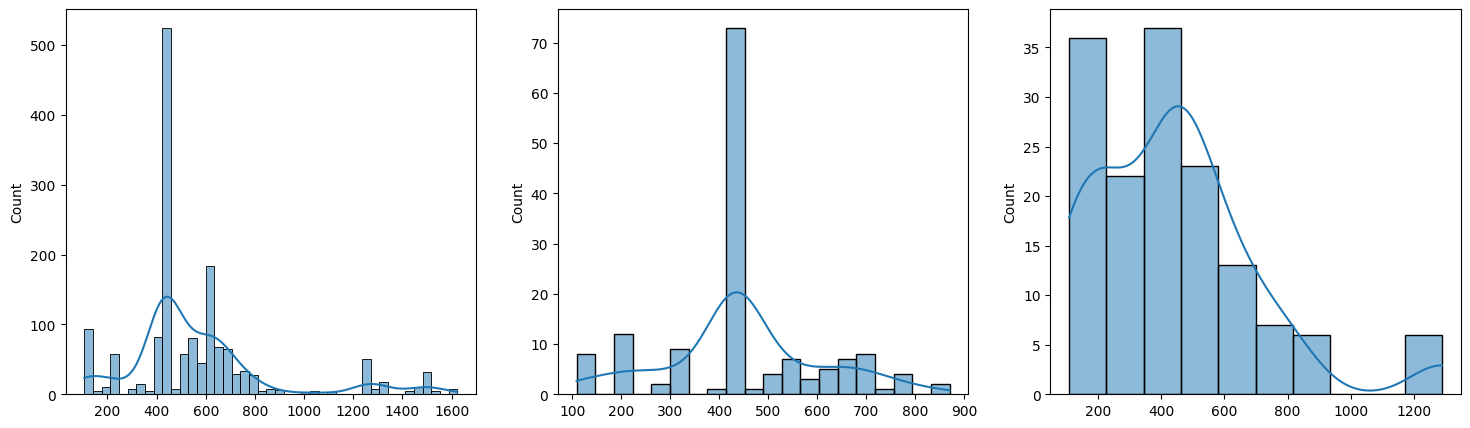

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(train_df['sequence'].apply(lambda x: len(x)).values, kde=True)
plt.subplot(1, 3, 2)
sns.histplot(valid_df['sequence'].apply(lambda x: len(x)).values, kde=True)
plt.subplot(1, 3, 3)
sns.histplot(test_df['sequence'].apply(lambda x: len(x)).values, kde=True);